<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/Sampler_Thresholding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imbalanced Dataset Sampler
(reference: https://github.com/ufoym/imbalanced-dataset-sampler) <br>
To solve imbalanced classes problem, a widely adopted technique is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling). Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

<img src="https://user-images.githubusercontent.com/2270240/40656410-e0baa230-6376-11e8-8904-c092fb38fcdc.png" alt="d">


In this imbalanced dataset sampler method, 

- rebalance the class distributions when sampling from the imbalanced dataset <br>
- estimate the sampling weights automatically <br>
- avoid creating a new balanced dataset <br>
- mitigate overfitting when it is used in conjunction with data augmentation techniques <br>

<img src="https://user-images.githubusercontent.com/2270240/40677251-b08f504a-63af-11e8-9653-f28e973a5664.png" alt="d">


Basic Script

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import os
import argparse
import copy
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
parser = argparse.ArgumentParser(description='BalancedLSF Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--batch_size', default=50, type=int, help='batch size')
parser.add_argument('--test_batch_size', default=2048, type=int, help='batch size')
parser.add_argument('--num_epoch', default=100, type=int, help='epoch number')
parser.add_argument('--num_classes', type=int, default=10, help='number classes')
parser.add_argument('--imb_factor', default=0.01, type=float, help='Imbalanced factor')
args = parser.parse_args(args=[])

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

CIFAR imbalanced Dataset:

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_type='exp', imb_factor=0.01, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor)
        self.gen_imbalanced_data(img_num_list)

    def get_labels(self):
        return self.targets

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

class IMBALANCECIFAR100(IMBALANCECIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }
    cls_num = 100

Installing Imbalanced Dataset Sampler:

In [ ]:
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

     - 297 kB 1.7 MB/s
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3839 sha256=0670102e5a82bfd7d5ea5620ae6e838db45181bb5a4b1a6a5066dc8891fc30f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9uofjta/wheels/52/7b/7d/ce0e0ddbb7864877a0e31a96f883a928791ebfa6eaf7b52f87
Successfully built torchsampler


Comparing Imbalanced Dataset Sampler over pytorch IID sampler:

In [ ]:
from torchsampler import ImbalancedDatasetSampler
seed_everything()
mean_cifar10, std_cifar10 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar10, std_cifar10), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar10, std_cifar10),])
#train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_dataset = IMBALANCECIFAR10(root='./data', imb_type='exp', imb_factor=args.imb_factor, rand_number=0, train=True, download=True, transform=transform_train)
print('Class frequency in Train Dataset',train_dataset.get_cls_num_list())

#Standard IID Batch Sampler
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,num_workers=4)
for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    cls_batch_sampler = [(targets==i).sum().item() for i in range(10)]
    print('Standard IID Batch Sampler:',cls_batch_sampler)
    break

#Imbalanced Dataset Sampler with library
train_loader_bal = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, num_workers=4, sampler=ImbalancedDatasetSampler(train_dataset))
for batch_idx, (inputs, targets) in enumerate(train_loader_bal):
    inputs, targets = inputs.to(device), targets.to(device)
    cls_batch_sampler = [(targets==i).sum().item() for i in range(10)]
    print('Imbalanced Dataset Sampler with Lib:',cls_batch_sampler)
    break


#Imbalanced Dataset Sampler with Pytorch sampler
class_sample_count = train_dataset.get_cls_num_list()
weights = 1. / torch.Tensor(class_sample_count)
samples_weight = torch.tensor([weights[t] for t in train_dataset.get_labels()])
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
trainloader_bal_pytorch = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, num_workers=4, sampler=sampler)
for batch_idx, (inputs, targets) in enumerate(train_loader_bal):
    inputs, targets = inputs.to(device), targets.to(device)
    cls_batch_sampler = [(targets==i).sum().item() for i in range(10)]
    print('Imbalanced Dataset Sampler with Pytorch:',cls_batch_sampler)
    break


Files already downloaded and verified
Class frequency in Train Dataset [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Standard IID Batch Sampler: [22, 9, 10, 2, 0, 4, 0, 2, 1, 0]
Imbalanced Dataset Sampler with Lib: [8, 5, 5, 4, 6, 5, 7, 3, 4, 3]
Imbalanced Dataset Sampler with Pytorch: [11, 3, 5, 3, 4, 5, 1, 6, 6, 6]


# Threshold-Moving for Imbalanced Classification

### 1. G-Mean = sqrt(Sensitivity * Specificity)


Before tuning F-Score: 0.70130
Best Threshold=0.016153, G-Mean=0.933


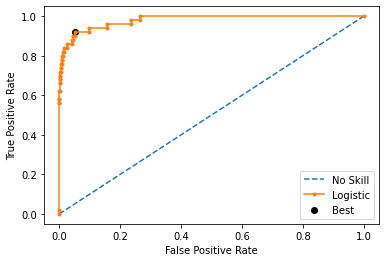

In [ ]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
#f1 score
yhat_lab = model.predict(testX)
fscore = f1_score(testy, yhat_lab)
print('Before tuning F-Score: %.5f' % fscore)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

### 2. Youden’s J statistic: J = Sensitivity + Specificity – 1 = TruePositiveRate – FalsePositiveRate

Before tuning F-Score: 0.70130
Best Threshold=0.016153


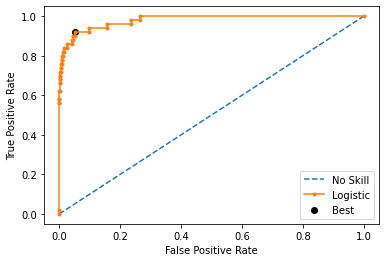

In [ ]:
# roc curve for logistic regression model with optimal threshold
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
#f1 score
yhat_lab = model.predict(testX)
fscore = f1_score(testy, yhat_lab)
print('Before tuning F-Score: %.5f' % fscore)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

### 3. Optimal Threshold for Precision-Recall Curve: F-Measure = (2 * Precision * Recall) / (Precision + Recall)

Before tuning F-Score: 0.70130
Best Threshold=0.256036, F-Score=0.756


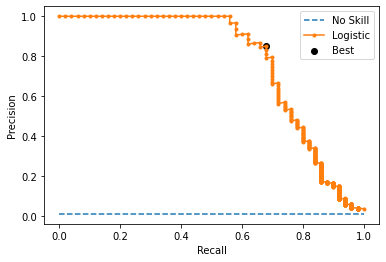

In [ ]:
# optimal threshold for precision-recall curve with logistic regression model
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
#f1 score
yhat_lab = model.predict(testX)
fscore = f1_score(testy, yhat_lab)
print('Before tuning F-Score: %.5f' % fscore)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(testy, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

### 4. Optimal Threshold Tuning Manually with different threshold

In [ ]:
# search thresholds for imbalanced classification
from numpy import arange
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict labels
yhat_lab = model.predict(testX)
# evaluate the model
score = f1_score(testy, yhat_lab)
print('Before tuning F-Score: %.5f' % score)

# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(testy, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Before tuning F-Score: 0.70130
Threshold=0.251, F-Score=0.75556


### G-means Vs. Target FPR=0.2 thresholding:

G-means:

Before tuning F-Score: 0.70130
Best Threshold=0.016153, G-Mean=0.933


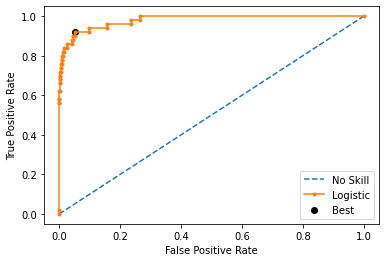

In [ ]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score

# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
#f1 score
yhat_lab = model.predict(testX)
fscore = f1_score(testy, yhat_lab)
print('Before tuning F-Score: %.5f' % fscore)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Target_fpr = 0.2

Before tuning F-Score: 0.70130


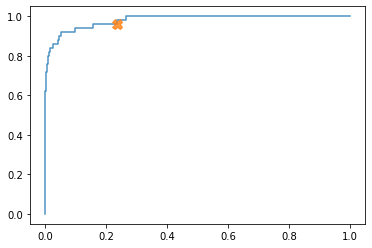

In [ ]:
# roc curve for logistic regression model with optimal threshold
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
#f1 score
yhat_lab = model.predict(testX)
fscore = f1_score(testy, yhat_lab)
print('Before tuning F-Score: %.5f' % fscore)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
roc_auc = auc(fpr, tpr)
target_fpr = 0.2
# global threshold
op = thresholds[np.argmin(np.abs(fpr-target_fpr))]
fpr_t = 1 - recall_score(testy, yhat>=op, pos_label=0)
tpr_t = recall_score(testy, yhat>=op, pos_label=1)
plt.plot(fpr, tpr, lw=1.5, alpha=.8, label='AUC=%0.2f' % roc_auc)
plt.plot(fpr_t, tpr_t, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t,fpr_t))

### Adding Decision Threshold tuning

In [ ]:
!pip -q install sklego

     |████████████████████████████████| 223 kB 5.0 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np

from sklego.datasets import load_hearts
from sklearn.model_selection import train_test_split

data = load_hearts(as_frame=True)
X, y = data.drop(columns='target'), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklego.preprocessing import PandasTypeSelector


cat_features_preprocessing = make_pipeline(PandasTypeSelector(exclude='number'),
                                           SimpleImputer(strategy='constant', fill_value='unknown'), 
                                           OneHotEncoder(categories=[['normal', 'sth', 'fixed']], handle_unknown='ignore'))

num_features_preprocessing = make_pipeline(PandasTypeSelector(include='number'),
                                           SimpleImputer(strategy='median'),
                                           StandardScaler())

preprocessor = make_union(cat_features_preprocessing, num_features_preprocessing)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression()
pipe = make_pipeline(preprocessor, model)

param_grid = {'logisticregression__C': np.logspace(-2, 1, 10)}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='average_precision',
                    n_jobs=-1, verbose=1, return_train_score=True)
grid.fit(X_train, y_train)

print(grid.best_score_)
best_model = grid.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.8032180617714472


/usr/local/lib/python3.7/dist-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


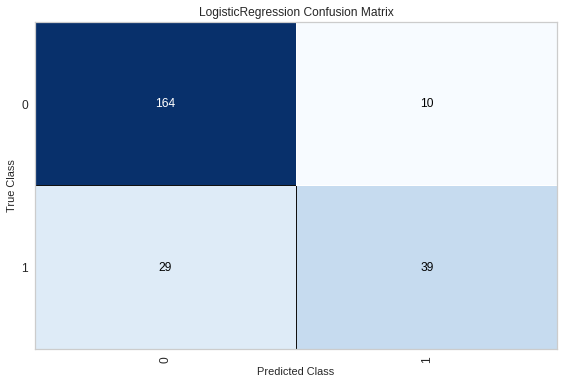

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(best_model, cmap='Blues')
cm.score(X_train, y_train)
cm.show();

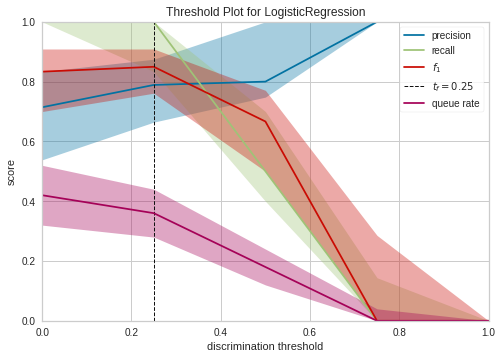

In [ ]:

from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(best_model, quantiles=np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)
visualizer.show(); 